In [7]:
import warnings

In [8]:
warnings.filterwarnings("ignore")

In [9]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from pmdarima import auto_arima

In [4]:
data = pd.read_csv("../NullValueHandled/ColomboProperHandledNullValues.csv", index_col=0, parse_dates=True)

In [5]:
data.head()

,Next Date,HCHO reading
Current Date,,
2019-01-01,2019-01-02,0.000197
2019-01-02,2019-01-03,0.000263
2019-01-03,2019-01-04,0.000099
2019-01-04,2019-01-05,0.000210
2019-01-05,2019-01-06,0.000179


In [616]:
colombo_data = data[["HCHO reading"]]
colombo_data.head()

,HCHO reading
Current Date,
2019-01-01,0.000197
2019-01-02,0.000263
2019-01-03,0.000099
2019-01-04,0.000210
2019-01-05,0.000179


In [617]:
colombo_data.shape

(1826, 1)

In [618]:
X = colombo_data.values

#### This looks like that colombo fomaldihyde rates have a seasonality

<Axes: xlabel='Current Date'>

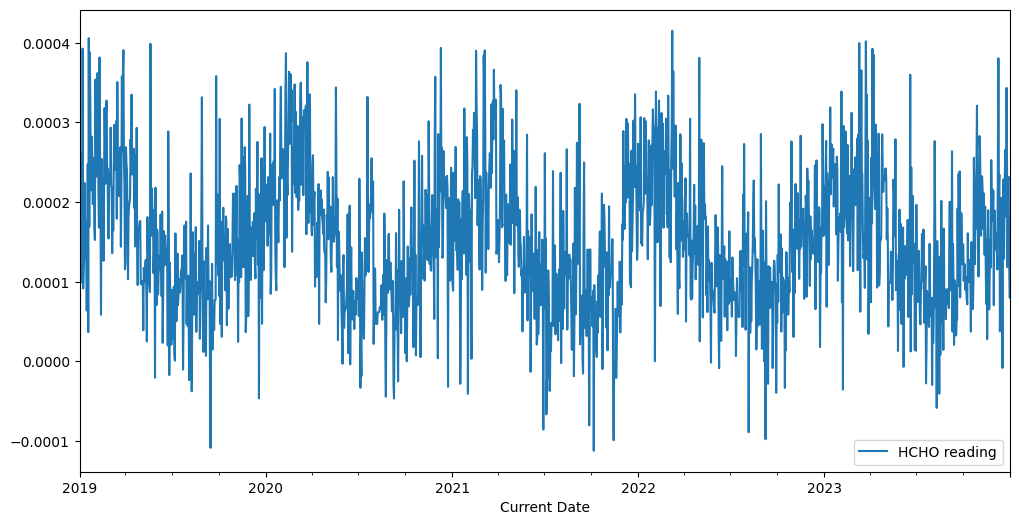

In [9]:
colombo_data.plot(figsize=(12, 6))

In [10]:
from statsmodels.tsa.stattools import adfuller

In [11]:
test_colombo = adfuller(colombo_data["HCHO reading"], autolag="AIC")

In [12]:
print("ADF value : ", test_colombo[0])
print("P value: ", test_colombo[1])
print("Num of Lags :", test_colombo[2])
print("Num of Observations used for ADF Regression and Critical Calculation :", test_colombo[3])
for key, val in test_colombo[4].items():
    print("\t", key, ": ", val)

ADF value :  -3.8828939837504732
P value:  0.0021644075534644367
Num of Lags : 16
Num of Observations used for ADF Regression and Critical Calculation : 1809
	 1% :  -3.4339700129534423
	 5% :  -2.8631390341376393
	 10% :  -2.567621272963846


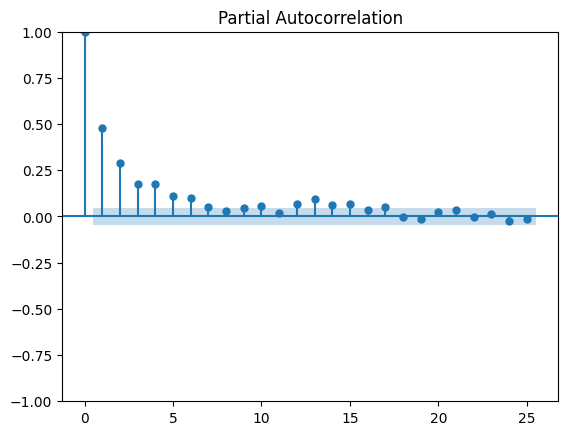

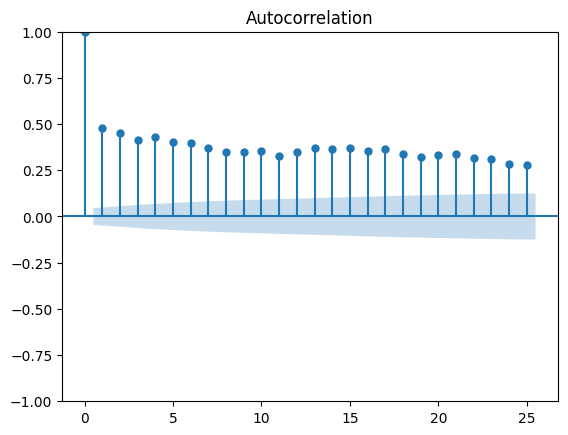

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(colombo_data["HCHO reading"], lags=25)
acf = plot_acf(colombo_data["HCHO reading"], lags=25) 

#### This Autocorrelation and Partial correlation plots show that there is a seasonality in colombo region data

In [14]:
(1826 / 100) * 80

1460.8000000000002

In [15]:
train=X[:1460]
test=X[1460:]

In [16]:
train[:5]

array([[1.96983440e-04],
       [2.62552217e-04],
       [9.85211890e-05],
       [2.09932052e-04],
       [1.78533730e-04]])

#### Based on the partial correlation plot, given 7 as the lag

In [24]:
# Import necessary libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import AutoReg

# Assuming train is already defined as a numpy array

# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
scaler.fit(train.reshape(-1, 1))
train_normalized = scaler.transform(train.reshape(-1, 1))

# Convert the normalized data back to a numpy array
train_normalized = train_normalized.flatten()

# Train the AutoReg model
model = AutoReg(train_normalized, lags=7).fit()


In [25]:
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1460
Model:                     AutoReg(7)   Log Likelihood                 896.814
Method:               Conditional MLE   S.D. of innovations              0.131
Date:                Tue, 09 Apr 2024   AIC                          -1775.628
Time:                        07:04:36   BIC                          -1728.096
Sample:                             7   HQIC                         -1757.893
                                 1460                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0868      0.014      6.041      0.000       0.059       0.115
y.L1           0.2307      0.026      8.839      0.000       0.180       0.282
y.L2           0.1355      0.027      5.082      0.0

In [26]:
# Make predictions using the trained model
predicted_normalized = model.predict(start=len(train_normalized), end=len(train_normalized) + len(test) - 1, dynamic=False)

# Inverse transform the predicted values to the original scale
predicted_values = scaler.inverse_transform(predicted_normalized.reshape(-1, 1)).flatten()

# Create a DataFrame for predicted values
predicted_df = pd.DataFrame(predicted_values, columns=['predicted'])

test = pd.DataFrame(test)
# Set the index of the predicted DataFrame to match the test data index
predicted_df.index = test.index

# Add the actual values from the test set to the DataFrame
predicted_df['actual'] = test

# Display the DataFrame with predicted and actual values
print(predicted_df.head())

   predicted    actual
0   0.000178  0.000157
1   0.000180  0.000220
2   0.000188  0.000210
3   0.000189  0.000160
4   0.000193  0.000242


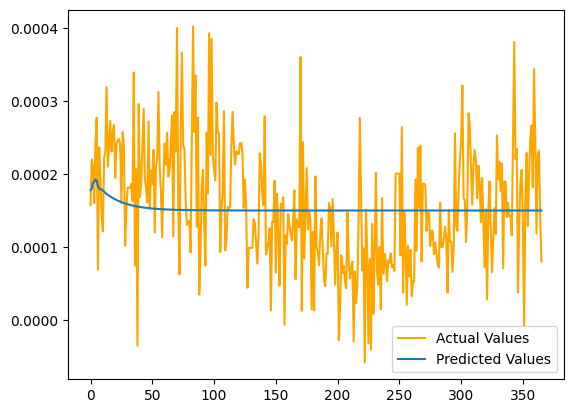

In [27]:
from matplotlib import pyplot

pyplot.plot(test, color="orange", label='Actual Values')
pyplot.plot(predicted_values, label='Predicted Values')
pyplot.legend()

In [28]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

# Assuming you have your test and predicted values stored in 'test' and 'predicted_values' variables

# Calculate the metrics
r_squared = r2_score(test, predicted_values)
mae = mean_absolute_error(test, predicted_values)
mse = mean_squared_error(test, predicted_values)
rmse = mean_squared_error(test, predicted_values, squared=False)
median_absolute = median_absolute_error(test, predicted_values)
explained_variance = explained_variance_score(test, predicted_values)

table_headers = ["Metric", "Value"]
table_data = {
    "R-squared (Coefficient of Determination)": "{:.12f}".format(r_squared),
    "Mean Absolute Error (MAE)": "{:.12f}".format(mae),
    "Mean Squared Error (MSE)": "{:.12f}".format(mse),
    "Root Mean Squared Error (RMSE)": "{:.12f}".format(rmse),
    "Median Absolute Error": "{:.12f}".format(median_absolute),
    "Explained Variance Score": "{:.12f}".format(explained_variance)
}

# Create DataFrame
df = pd.DataFrame(table_data.items(), columns=table_headers)

df

,Metric,Value
0,R-squared (Coefficient of Determination),0.025047722897
1,Mean Absolute Error (MAE),0.000064590201
2,Mean Squared Error (MSE),0.000000006531
3,Root Mean Squared Error (RMSE),0.000080814843
4,Median Absolute Error,0.000056364311
5,Explained Variance Score,0.027318766835


#### This shows that above model does not perform well with the R2 score

### Check moving average on the colombo data

In [29]:
colombo_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HCHO reading  1826 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Define the scaler
scaler = MinMaxScaler()

train = pd.DataFrame(train) 

# Fit the scaler to the training data and transform it
scaler.fit(train[[0]])
train_normalized = scaler.transform(train[[0]])

# Convert the normalized data back to a numpy array
train_normalized = train_normalized.flatten()

arima_model = ARIMA(train_normalized, order=(0, 0, 25))
arima_model = arima_model.fit()
arima_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1460
Model:                ARIMA(0, 0, 25)   Log Likelihood                 906.378
Date:                Tue, 09 Apr 2024   AIC                          -1758.757
Time:                        07:05:02   BIC                          -1616.030
Sample:                             0   HQIC                         -1705.514
                               - 1460                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4989      0.015     33.453      0.000       0.470       0.528
ma.L1          0.2252      0.026      8.541      0.000       0.174       0.277
ma.L2          0.1803      0.027      6.753      0.000       0.128       0.233
ma.L3          0.1696      0.029      5.940      0.000       0.114       0.225
ma.L4          0.1947      0.029      6.651      0.000       0.137       0.252
ma.L5          0.1772      0.030      5.907      0.000       0.118       0.236
ma.L6          0.2049      0.030      6.885      0.000       0.147       0.263
ma.L7          0.1680      0.029      5.814      0.000       0.111       0.225
ma.L8          0.1218      0.030      4.019      0.000       0.062       0.181
ma.L9          0.1498      0.030      4.978      0.000       0.091       0.209
ma.L10         0.1280      0.032      3.977      0.000       0.065       0.191
ma.L11         0.0793      0.028      2.783      0.005       0.023       0.135
ma.L12         0.1013      0.029      3.529      0.000       0.045       0.158
ma.L13         0.1392      0.030      4.667      0.000       0.081       0.198
ma.L14         0.1239      0.030      4.071      0.000       0.064       0.184
ma.L15         0.1630      0.029      5.594      0.000       0.106       0.220
ma.L16         0.1152      0.030      3.900      0.000       0.057       0.173
ma.L17         0.1675      0.031      5.469      0.000       0.107       0.227
ma.L18         0.0917      0.030      3.047      0.002       0.033       0.151
ma.L19         0.0864      0.029      2.935      0.003       0.029       0.144
ma.L20         0.0930      0.030      3.111      0.002       0.034       0.152
ma.L21         0.1095      0.030      3.673      0.000       0.051       0.168
ma.L22         0.0808      0.030      2.735      0.006       0.023       0.139
ma.L23         0.1061      0.029      3.650      0.000       0.049       0.163
ma.L24         0.0220      0.027      0.820      0.412      -0.031       0.074
ma.L25         0.0439      0.026      1.665      0.096      -0.008       0.096
sigma2         0.0169      0.001     32.845      0.000       0.016       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               100.45
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.16
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
start = len(train)
end = len(train) + len(test) - 1
predicted_values = pd.DataFrame(scaler.inverse_transform(arima_model.predict(start=start, end=end, type="levels").reshape(-1, 1)))
predicted_values.index = colombo_data.index[start:end + 1]

In [32]:
predicted_values.head()

,0
Current Date,
2022-12-31,0.000195
2023-01-01,0.000186
2023-01-02,0.000191
2023-01-03,0.000195
2023-01-04,0.000196


In [33]:
predicted_values.rename(columns={0:"predicted"}, inplace=True)

In [34]:
predicted_values["actual"] = test[0].values

In [35]:
predicted_values.head()

,predicted,actual
Current Date,,
2022-12-31,0.000195,0.000157
2023-01-01,0.000186,0.000220
2023-01-02,0.000191,0.000210
2023-01-03,0.000195,0.000160
2023-01-04,0.000196,0.000242


<Axes: xlabel='Current Date'>

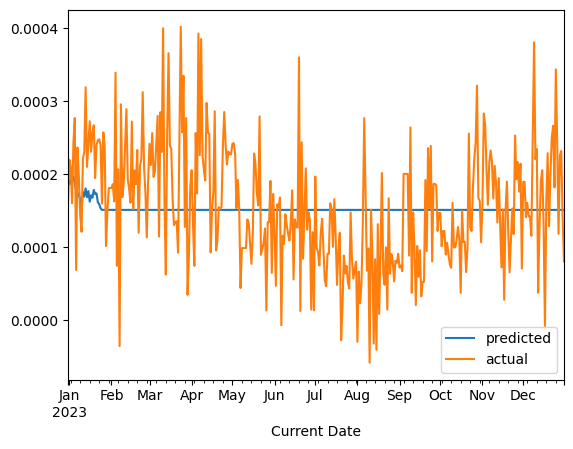

In [36]:
predicted_values.plot(legend=True)

In [37]:
from tabulate import tabulate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, explained_variance_score

# Assuming you have your test and predicted values stored in 'test' and 'predicted_values' variables

predicted_values = predicted_values["predicted"]

# Calculate the metrics
r_squared = r2_score(test, predicted_values)
mae = mean_absolute_error(test, predicted_values)
mse = mean_squared_error(test, predicted_values)
rmse = mean_squared_error(test, predicted_values, squared=False)
median_absolute = median_absolute_error(test, predicted_values)
explained_variance = explained_variance_score(test, predicted_values)

table_headers = ["Metric", "Value"]
table_data = {
    "R-squared (Coefficient of Determination)": "{:.12f}".format(r_squared),
    "Mean Absolute Error (MAE)": "{:.12f}".format(mae),
    "Mean Squared Error (MSE)": "{:.12f}".format(mse),
    "Root Mean Squared Error (RMSE)": "{:.12f}".format(rmse),
    "Median Absolute Error": "{:.12f}".format(median_absolute),
    "Explained Variance Score": "{:.12f}".format(explained_variance)
}

# Create DataFrame
df = pd.DataFrame(table_data.items(), columns=table_headers)

df

,Metric,Value
0,R-squared (Coefficient of Determination),0.021022444682
1,Mean Absolute Error (MAE),0.000064860961
2,Mean Squared Error (MSE),0.000000006558
3,Root Mean Squared Error (RMSE),0.000080981501
4,Median Absolute Error,0.000055790286
5,Explained Variance Score,0.022708903114


#### Check SARIMA Model

In [66]:
colombo_data.shape

(1826, 1)

In [67]:
data = train

In [68]:
data.head()

,0
0,0.000197
1,0.000263
2,0.000099
3,0.000210
4,0.000179


<Axes: >

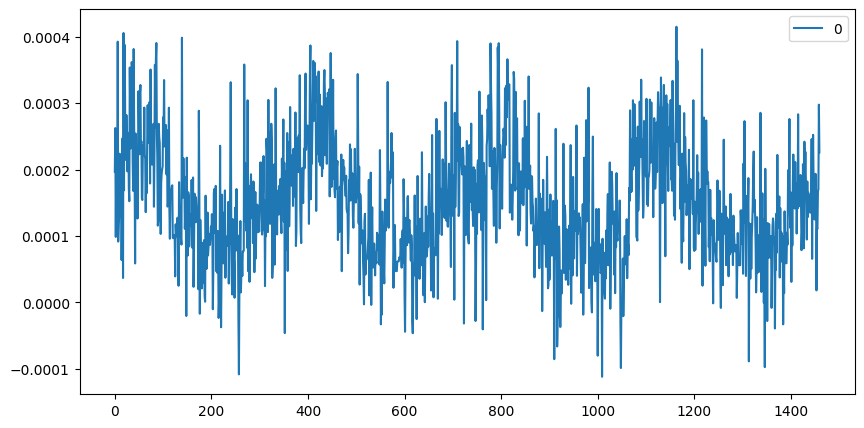

In [69]:
data.plot(figsize=(10, 5))

#### There is a seasonality in the data set therefore the trend should be removed

In [77]:
data = pd.read_csv("../NullValueHandled/ColomboProperHandledNullValues.csv", index_col=0, parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

train = data.iloc[:1460]
test = data.iloc[1461:]

In [83]:
from pmdarima import auto_arima

arema_steps = auto_arima(y=train['HCHO reading'],m=12)
arema_steps.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1460
Model:               SARIMAX(2, 1, 2)   Log Likelihood               11906.980
Date:                Tue, 09 Apr 2024   AIC                         -23801.960
Time:                        07:40:40   BIC                         -23770.247
Sample:                    01-01-2019   HQIC                        -23790.130
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -6.399e-08    5.9e-07     -0.109      0.914   -1.22e-06    1.09e-06
ar.L1         -0.5997   5.26e-13  -1.14e+12      0.000      -0.600      -0.600
ar.L2          0.0590   9.31e-13   6.34e+10      0.000       0.059       0.059
ma.L1         -0.1425   1.01e-12  -1.41e+11      0.000      -0.142      -0.142
ma.L2         -0.5401   1.93e-12   -2.8e+11      0.000      -0.540      -0.540
sigma2      4.856e-09   1.54e-10     31.630      0.000    4.56e-09    5.16e-09
===================================================================================
Ljung-Box (L1) (Q):                   1.72   Jarque-Bera (JB):               127.14
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.15
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.91e+27. Standard errors may be unstable.
"""

In [88]:
#Predictions
predictions = pd.Series(arema_steps.predict(n_periods = len(test)))
predictions.index = test.index
predictions[:5]

Current Date
2023-01-01    0.000191
2023-01-02    0.000185
2023-01-03    0.000186
2023-01-04    0.000185
2023-01-05    0.000186
dtype: float64

<Axes: xlabel='Current Date'>

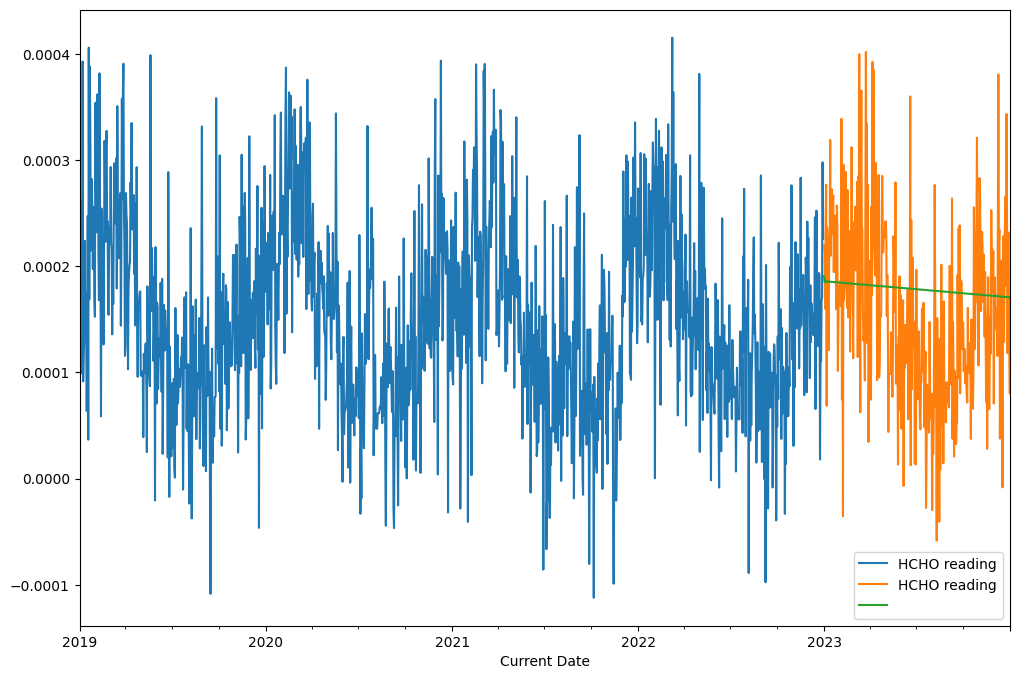

In [89]:
#Visualization
train['HCHO reading']['2019-01-01':].plot(figsize = (12,8), legend = True)
test['HCHO reading'].plot( legend = True)
predictions.plot(legend = True)

In [90]:
order = (2, 1, 2)
seasonal_order = (0, 0, 0, 12) 
sarima_model = SARIMAX(train['HCHO reading'], order=order, seasonal_order=seasonal_order)

In [91]:
# Fit the SARIMA model
sarima_result = sarima_model.fit()

# Print the summary of the SARIMA model
print(sarima_result.summary())

                               SARIMAX Results                                
Dep. Variable:           HCHO reading   No. Observations:                 1460
Model:               SARIMAX(2, 1, 2)   Log Likelihood               11895.371
Date:                Tue, 09 Apr 2024   AIC                         -23780.741
Time:                        07:45:29   BIC                         -23754.314
Sample:                    01-01-2019   HQIC                        -23770.883
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5997    9.4e-20  -6.38e+18      0.000      -0.600      -0.600
ar.L2          0.0590   6.54e-20   9.02e+17      0.000       0.059       0.059
ma.L1         -0.1425   3.23e-19  -4.41e+17      0.0

In [102]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("../NullValueHandled/ColomboProperHandledNullValues.csv", index_col=0, parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

# Choose a column for modeling
column_name = 'HCHO reading'  # Replace 'YourColumnNameHere' with the actual column name
train = data[column_name]

# Fill missing values using interpolation
train = train.interpolate(method='linear')

# Remove seasonality
decomposition = seasonal_decompose(train, model='additive')
train_seasonality_removed = train - decomposition.seasonal

# Split data into train and test sets
train = train_seasonality_removed.iloc[:1700]
test = train_seasonality_removed.iloc[1700:]

# Find the best ARIMA model using auto_arima
model = auto_arima(train, seasonal=True, m=12)

# Fit SARIMA model
model.fit(train)

# Forecast
forecast = model.predict(n_periods=len(test))

# Add back the seasonal component to the forecast
forecast_with_seasonality = forecast + decomposition.seasonal[-len(test):]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast_with_seasonality, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMA Forecast with Seasonality')
plt.legend()
plt.show()


KeyboardInterrupt: 

#### It shows that these models do not support well, therefore tried with deep learning techniques

#### Using LSTM Model 

In [39]:
data = pd.read_csv("../NullValueHandled/ColomboProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [40]:
print(data.head())

  Current Date  HCHO reading
0   2019-01-01      0.000197
1   2019-01-02      0.000263
2   2019-01-03      0.000099
3   2019-01-04      0.000210
4   2019-01-05      0.000179


In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

# Assuming 'data' is your DataFrame and you've loaded it successfully

# Preprocess data
data['Current Date'] = pd.to_datetime(data['Current Date'])
data.sort_values(by='Current Date', inplace=True)
data.set_index('Current Date', inplace=True)

# Split data into train and test sets
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, -1])  # Assuming target is the last column
    return np.array(X), np.array(y)

sequence_length = 5 # Adjust sequence length as necessary

# Create sequences for training and testing data
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

model = Sequential([
    Bidirectional(LSTM(units=500, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=400, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=200, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=100, return_sequences=True)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10)),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
37/37 [==============================] - 34s 268ms/step - loss: 0.8788 - mean_squared_error: 0.8788 - val_loss: 0.6737 - val_mean_squared_error: 0.6737
Epoch 2/100
37/37 [==============================] - 4s 116ms/step - loss: 0.7594 - mean_squared_error: 0.7594 - val_loss: 0.5966 - val_mean_squared_error: 0.5966
Epoch 3/100
37/37 [==============================] - 4s 113ms/step - loss: 0.7272 - mean_squared_error: 0.7272 - val_loss: 0.5926 - val_mean_squared_error: 0.5926
Epoch 4/100
37/37 [==============================] - 4s 110ms/step - loss: 0.7181 - mean_squared_error: 0.7181 - val_loss: 0.8646 - val_mean_squared_error: 0.8646
Epoch 5/100
37/37 [==============================] - 4s 113ms/step - loss: 0.7038 - mean_squared_error: 0.7038 - val_loss: 0.5769 - val_mean_squared_error: 0.5769
Epoch 6/100
37/37 [==============================] - 4s 113ms/step - loss: 0.7178 - mean_squared_error: 0.7178 - val_loss: 0.5563 - val_mean_squared_error: 0.5563
Epoch 7/100
37/37 [==

37/37 [==============================] - 4s 113ms/step - loss: 0.5983 - mean_squared_error: 0.5983 - val_loss: 0.6712 - val_mean_squared_error: 0.6712
Epoch 52/100
37/37 [==============================] - 4s 121ms/step - loss: 0.5828 - mean_squared_error: 0.5828 - val_loss: 0.6200 - val_mean_squared_error: 0.6200
Epoch 53/100
37/37 [==============================] - 4s 121ms/step - loss: 0.5681 - mean_squared_error: 0.5681 - val_loss: 0.6733 - val_mean_squared_error: 0.6733
Epoch 54/100
37/37 [==============================] - 4s 118ms/step - loss: 0.5770 - mean_squared_error: 0.5770 - val_loss: 0.6850 - val_mean_squared_error: 0.6850
Epoch 55/100
37/37 [==============================] - 5s 140ms/step - loss: 0.5739 - mean_squared_error: 0.5739 - val_loss: 0.6284 - val_mean_squared_error: 0.6284
Epoch 56/100
37/37 [==============================] - 4s 122ms/step - loss: 0.5457 - mean_squared_error: 0.5457 - val_loss: 0.5851 - val_mean_squared_error: 0.5851
Epoch 57/100
37/37 [=========

12/12 [==============================] - 6s 30ms/step


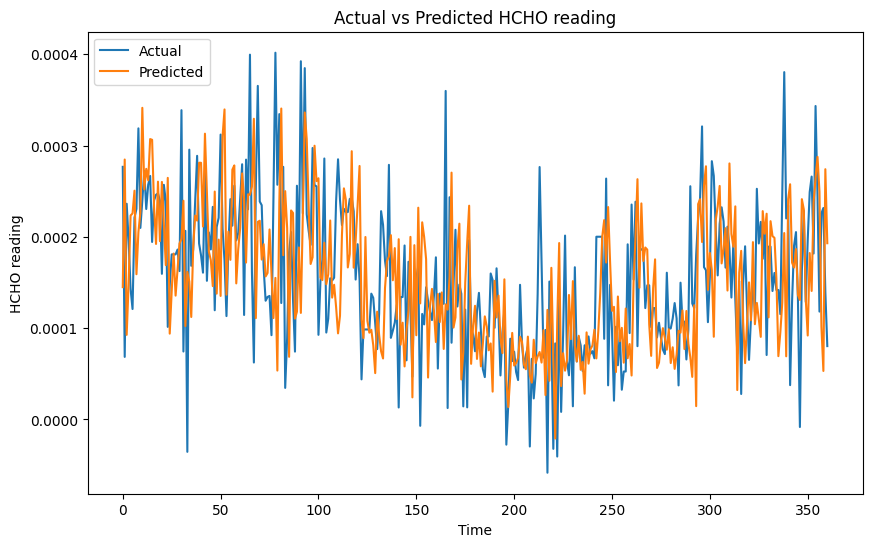

In [42]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 1s 32ms/step


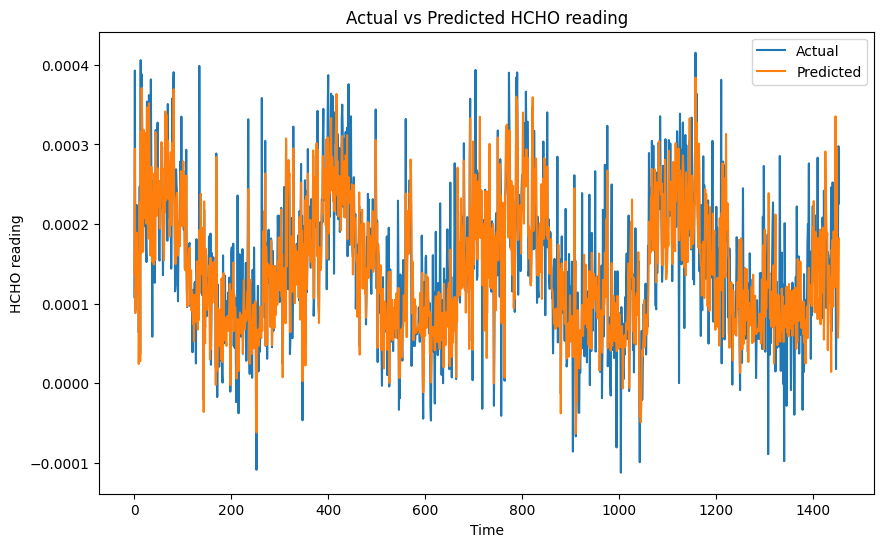

In [43]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled = model.predict(X_train)

# Inverse transform predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

46/46 [==============================] - 1s 30ms/step


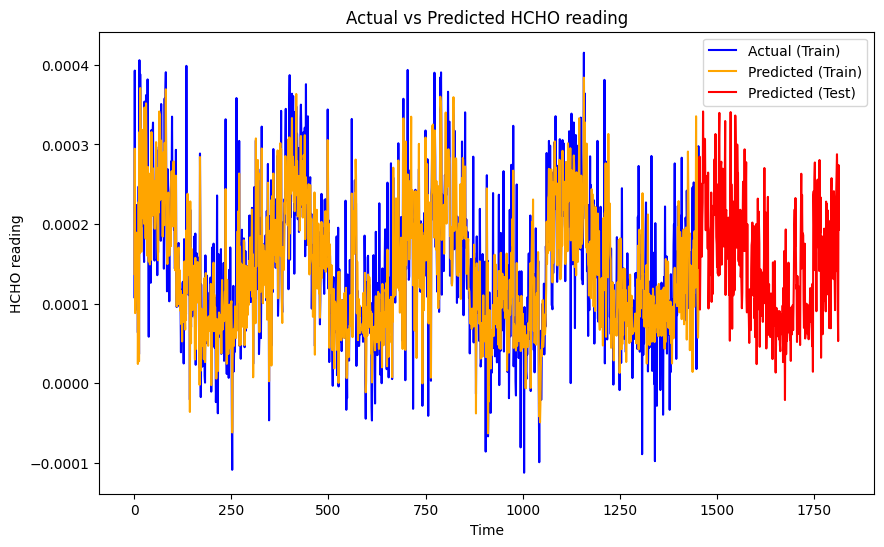

In [44]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler.inverse_transform(predictions_scaled_test)
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler.inverse_transform(predictions_scaled_train)
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_train, label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [45]:
y_test = actual
predicted_values = predictions.reshape(-1, 1)
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.6192504942499758
Mean Absolute Error (MAE): 3.75956467974311e-05
Mean Squared Error (MSE): 2.919476431556038e-09
Root Mean Squared Error (RMSE): 5.40321795928689e-05
Median Absolute Error: 2.5028063278461143e-05
Explained Variance Score: 0.6243512877464827


#### Using Facebook Prophet Model

23:44:42 - cmdstanpy - INFO - Chain [1] start processing
23:44:42 - cmdstanpy - INFO - Chain [1] done processing


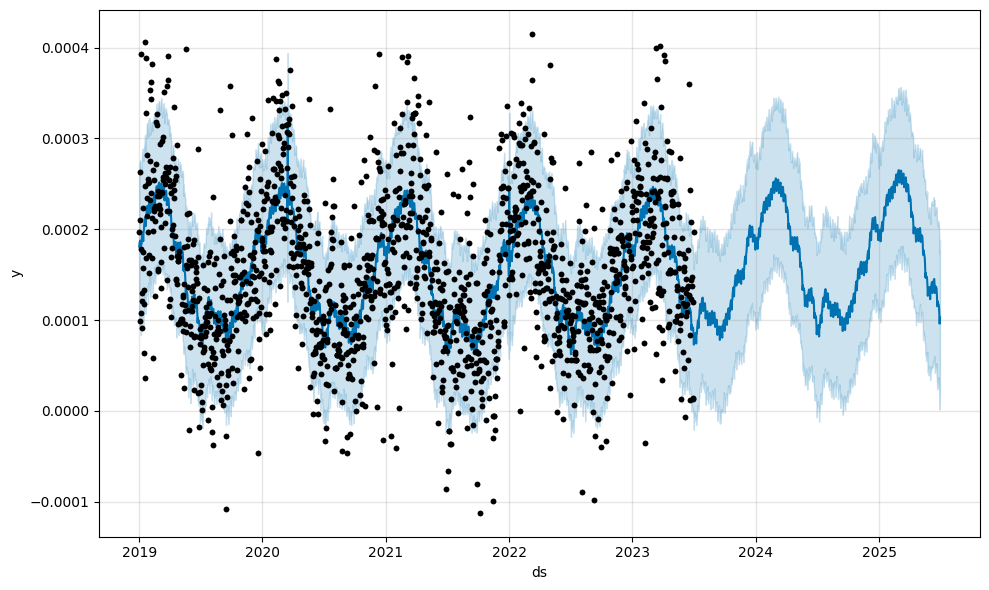

In [35]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare your data
data = pd.read_csv("../NullValueHandled/ColomboProperHandledNullValues.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data.rename(columns={'Current Date': 'ds', 'HCHO reading': 'y'}, inplace=True)
data['ds'] = pd.to_datetime(data['ds'])

# Define holidays
holidays = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(['2020-03-15', '2021-03-01']), 
    'lower_window': 0,
    'upper_window': 1,
})

train_size = int(0.90 * len(data)) 
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Initialize and fit the Prophet model with holidays
model = Prophet(holidays=holidays, 
               changepoint_prior_scale=0.50, 
               seasonality_prior_scale=5,) 
model.fit(train_data)

# Create a dataframe for future dates predictions
future = model.make_future_dataframe(periods=730)

# Make predictions
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
ax = fig1.gca()

# Overlay actual data
ax.plot(train_data['ds'], train_data['y'], 'k.', label='Actual Data')

plt.show()


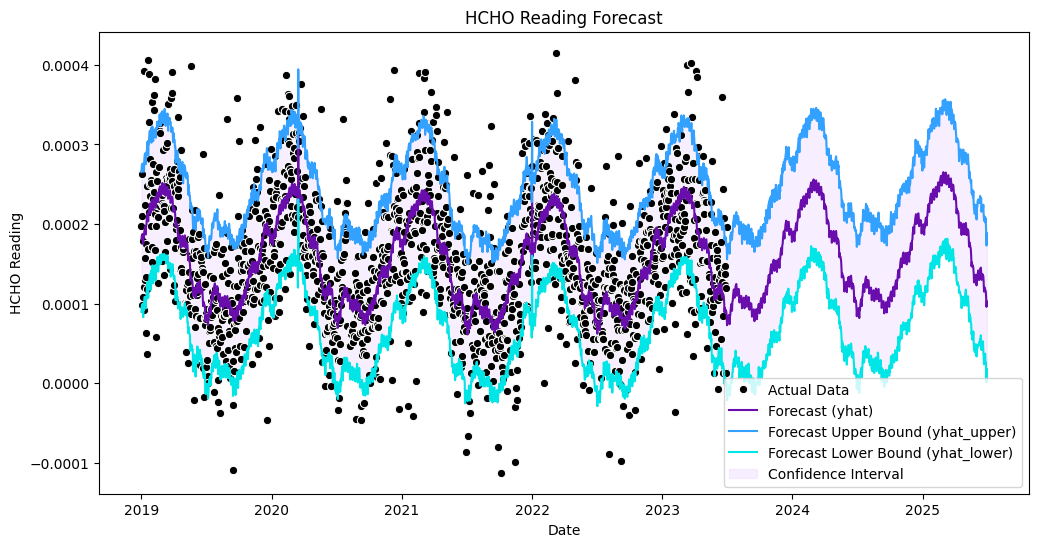

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot actual data
sns.lineplot(data=train_data, x='ds', y='y', label='Actual Data', color='black', marker='o', linestyle='None')

# Plot yhat - forecast
sns.lineplot(data=forecast, x='ds', y='yhat', label='Forecast (yhat)', color='#6a0dad')  # Purple

# Plot yhat_upper
sns.lineplot(data=forecast, x='ds', y='yhat_upper', label='Forecast Upper Bound (yhat_upper)', color='#33a1ff')  # Teal

# Plot yhat_lower
sns.lineplot(data=forecast, x='ds', y='yhat_lower', label='Forecast Lower Bound (yhat_lower)', color='#00e6e6')  # Light Teal

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='#d9b3ff', alpha=0.2, label='Confidence Interval')  # Light Purple

plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('HCHO Reading Forecast')

# Adjust legend
plt.legend()

plt.show()

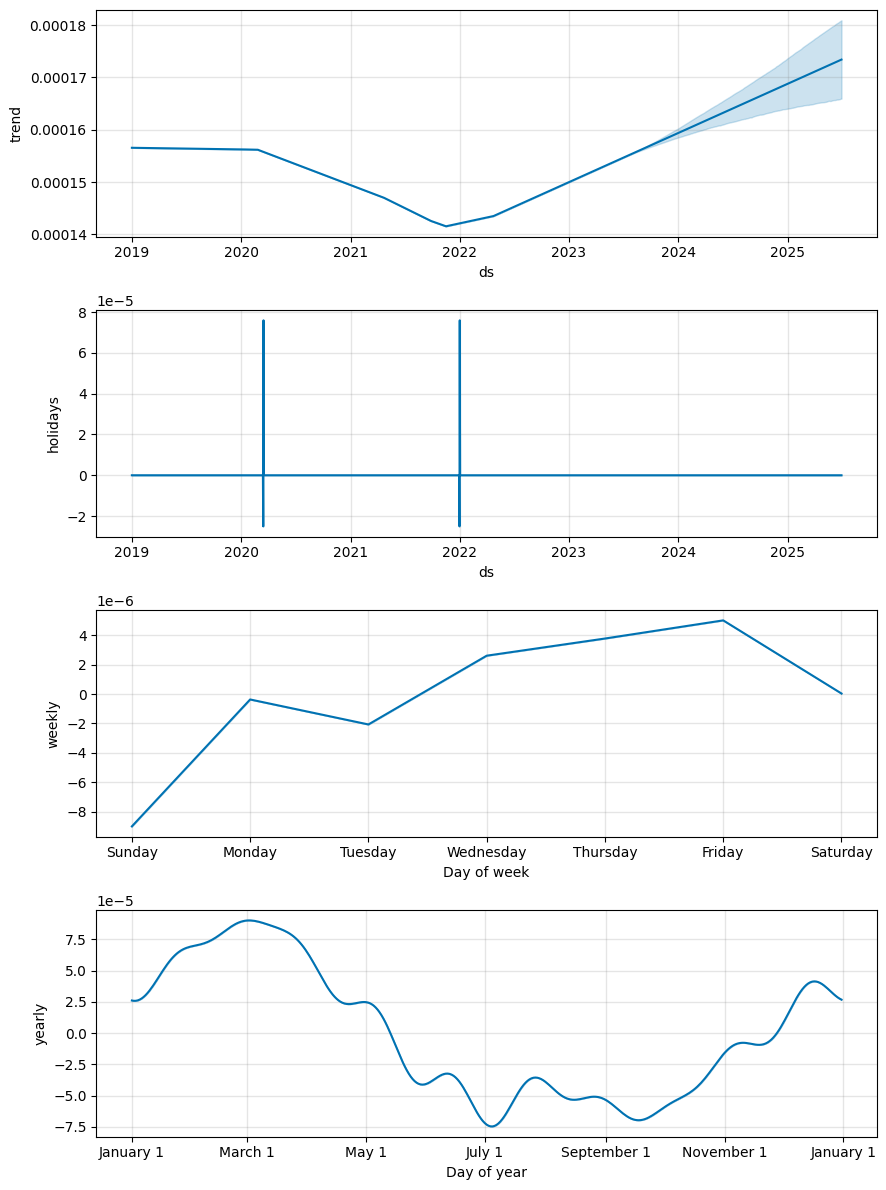

In [37]:
# Plot the forecast components
fig2 = model.plot_components(forecast)

In [38]:
y_test = test_data['y']
predicted_values = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat']  # Extract forecasted values for test period
r2 = r2_score(y_test, predicted_values)
mae = mean_absolute_error(y_test, predicted_values)
mse = mean_squared_error(y_test, predicted_values)
rmse = mean_squared_error(y_test, predicted_values, squared=False)
median_absolute = median_absolute_error(y_test, predicted_values)
explained_variance = explained_variance_score(y_test, predicted_values)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.16926808253535008
Mean Absolute Error (MAE): 5.176788473948816e-05
Mean Squared Error (MSE): 4.6405727135701e-09
Root Mean Squared Error (RMSE): 6.812174919634771e-05
Median Absolute Error: 4.061562952289058e-05
Explained Variance Score: 0.171769143416177


#### Build Multi Variate Models

In [179]:
data = pd.read_csv("../AnalysedFinalData/colomboData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Current Date          1826 non-null   object 
 1   HCHO reading          1826 non-null   float64
 2   Region                1826 non-null   object 
 3   LATITUDE              1826 non-null   float64
 4   LONGITUDE             1826 non-null   float64
 5   ELEVATION             1826 non-null   float64
 6   PRCP                  1826 non-null   float64
 7   TAVG                  1826 non-null   float64
 8   TMAX                  1826 non-null   float64
 9   TMIN                  1826 non-null   float64
 10  Population            1826 non-null   int64  
 11  Area_sq_km            1826 non-null   int64  
 12  population_density    1826 non-null   float64
 13  Proximity(km)         1826 non-null   int64  
 14  carbon_monoxide       1826 non-null   float64
 15  nitogen_dioxide      

In [136]:
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [137]:
data.head()

,Current Date,HCHO reading,Region,LATITUDE,LONGITUDE,ELEVATION,PRCP,TAVG,TMAX,TMIN,Population,Area_sq_km,population_density,Proximity(km),carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000197,Colombo Proper,6.9,79.867,7.0,0.0,81.0,89.0,74.0,2448000,699,3502.15,0,0.040408,0.000030,0.1163,0,0,Before,Before
1,2019-01-02,0.000263,Colombo Proper,6.9,79.867,7.0,0.0,78.0,89.0,74.0,2448000,699,3502.15,0,0.040408,0.000031,0.1163,0,0,Before,Before
2,2019-01-03,0.000099,Colombo Proper,6.9,79.867,7.0,0.0,81.0,90.0,74.0,2448000,699,3502.15,0,0.034717,0.000025,0.1163,0,0,Before,Before
3,2019-01-04,0.000210,Colombo Proper,6.9,79.867,7.0,0.0,81.0,91.0,72.0,2448000,699,3502.15,0,0.036808,0.000029,0.1163,0,0,Before,Before
4,2019-01-05,0.000179,Colombo Proper,6.9,79.867,7.0,0.0,81.0,90.0,74.0,2448000,699,3502.15,0,0.035529,0.000026,0.1163,0,0,Before,Before


#### remove constant data

In [138]:
data.columns

Index(['Current Date', 'HCHO reading', 'Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'Population', 'Area_sq_km',
       'population_density', 'Proximity(km)', 'carbon_monoxide',
       'nitogen_dioxide', 'ozone', 'new_covid_patients',
       'total_covid_patients', 'lockdown_status', 'covid_range_status'],
      dtype='object')

In [139]:
data.drop(columns=['Region', 'LATITUDE', 'LONGITUDE',
       'ELEVATION','Area_sq_km', 'Proximity(km)'], inplace=True)

In [140]:
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000197,0.0,81.0,89.0,74.0,2448000,3502.15,0.040408,0.000030,0.1163,0,0,Before,Before
1,2019-01-02,0.000263,0.0,78.0,89.0,74.0,2448000,3502.15,0.040408,0.000031,0.1163,0,0,Before,Before
2,2019-01-03,0.000099,0.0,81.0,90.0,74.0,2448000,3502.15,0.034717,0.000025,0.1163,0,0,Before,Before
3,2019-01-04,0.000210,0.0,81.0,91.0,72.0,2448000,3502.15,0.036808,0.000029,0.1163,0,0,Before,Before
4,2019-01-05,0.000179,0.0,81.0,90.0,74.0,2448000,3502.15,0.035529,0.000026,0.1163,0,0,Before,Before


#### Encode Categorical data

In [141]:
from sklearn.preprocessing import LabelEncoder
 
dates = data["Current Date"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in the DataFrame
for column in data.columns:
    # Check if the column is of categorical type
    if data[column].dtype == 'object':
        # Fit label encoder and transform values
        data[column] = label_encoder.fit_transform(data[column])

In [142]:
data["Current Date"] = dates
data.head()

,Current Date,HCHO reading,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status,covid_range_status
0,2019-01-01,0.000197,0.0,81.0,89.0,74.0,2448000,3502.15,0.040408,0.000030,0.1163,0,0,1,1
1,2019-01-02,0.000263,0.0,78.0,89.0,74.0,2448000,3502.15,0.040408,0.000031,0.1163,0,0,1,1
2,2019-01-03,0.000099,0.0,81.0,90.0,74.0,2448000,3502.15,0.034717,0.000025,0.1163,0,0,1,1
3,2019-01-04,0.000210,0.0,81.0,91.0,72.0,2448000,3502.15,0.036808,0.000029,0.1163,0,0,1,1
4,2019-01-05,0.000179,0.0,81.0,90.0,74.0,2448000,3502.15,0.035529,0.000026,0.1163,0,0,1,1


#### Check correlations

In [143]:
corr = data.corr(numeric_only=True)["HCHO reading"]
corr = pd.DataFrame(corr)
corr

,HCHO reading
HCHO reading,1.000000
PRCP,-0.093883
TAVG,-0.056770
TMAX,0.337612
TMIN,-0.235119
Population,-0.059603
population_density,-0.059608
carbon_monoxide,0.548224
nitogen_dioxide,0.516773
ozone,-0.353562


In [144]:
corr.to_csv("../OtherData/ColomboCorrelationData.csv")

In [145]:
data.shape

(1826, 15)

#### remove covid range status

In [146]:
data.drop(columns=["covid_range_status"], inplace=True)

#### Devide X and Y

In [147]:
X = data.drop(columns=["HCHO reading"])
y = data["HCHO reading"]

In [148]:
X.head()

,Current Date,PRCP,TAVG,TMAX,TMIN,Population,population_density,carbon_monoxide,nitogen_dioxide,ozone,new_covid_patients,total_covid_patients,lockdown_status
0,2019-01-01,0.0,81.0,89.0,74.0,2448000,3502.15,0.040408,0.000030,0.1163,0,0,1
1,2019-01-02,0.0,78.0,89.0,74.0,2448000,3502.15,0.040408,0.000031,0.1163,0,0,1
2,2019-01-03,0.0,81.0,90.0,74.0,2448000,3502.15,0.034717,0.000025,0.1163,0,0,1
3,2019-01-04,0.0,81.0,91.0,72.0,2448000,3502.15,0.036808,0.000029,0.1163,0,0,1
4,2019-01-05,0.0,81.0,90.0,74.0,2448000,3502.15,0.035529,0.000026,0.1163,0,0,1


#### Select features based on Correlations

In [149]:
data.corr(numeric_only=True)["HCHO reading"]

HCHO reading            1.000000
PRCP                   -0.093883
TAVG                   -0.056770
TMAX                    0.337612
TMIN                   -0.235119
Population             -0.059603
population_density     -0.059608
carbon_monoxide         0.548224
nitogen_dioxide         0.516773
ozone                  -0.353562
new_covid_patients     -0.067195
total_covid_patients   -0.069674
lockdown_status        -0.058338
Name: HCHO reading, dtype: float64

In [150]:
X = X[["Current Date", "carbon_monoxide", "nitogen_dioxide", "TMAX", "ozone"]]
X.head() 

,Current Date,carbon_monoxide,nitogen_dioxide,TMAX,ozone
0,2019-01-01,0.040408,0.000030,89.0,0.1163
1,2019-01-02,0.040408,0.000031,89.0,0.1163
2,2019-01-03,0.034717,0.000025,90.0,0.1163
3,2019-01-04,0.036808,0.000029,91.0,0.1163
4,2019-01-05,0.035529,0.000026,90.0,0.1163


#### Standardize, variable data

In [151]:
from sklearn.preprocessing import StandardScaler
# Select columns of interest
selected_columns = ["carbon_monoxide", "nitogen_dioxide", "TMAX", "ozone"]

# Convert "Current Date" to datetime format
data["Current Date"] = pd.to_datetime(data["Current Date"])

# Separate the "Current Date" column
current_date = data["Current Date"]

# Select only the columns you're interested in for standardization
X = X[selected_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the data
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)

# Concatenate "Current Date" column with the scaled data
X = pd.concat([current_date, X_scaled_df], axis=1)

X.set_index("Current Date", inplace=True)


In [152]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2019-01-01 to 2023-12-31
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   carbon_monoxide  1826 non-null   float64
 1   nitogen_dioxide  1826 non-null   float64
 2   TMAX             1826 non-null   float64
 3   ozone            1826 non-null   float64
dtypes: float64(4)
memory usage: 71.3 KB


##### Standardize target variable

In [153]:
y = data['HCHO reading']

y.head()

0    0.000197
1    0.000263
2    0.000099
3    0.000210
4    0.000179
Name: HCHO reading, dtype: float64

In [154]:
from sklearn.preprocessing import MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = np.array(scaler_y.fit_transform(y.values.reshape(-1, 1)), ndmin=1)

In [155]:
y_scaled[:5]

array([[0.58629309],
       [0.71064732],
       [0.39955487],
       [0.61085073],
       [0.55130236]])

In [156]:
X_scaled = X

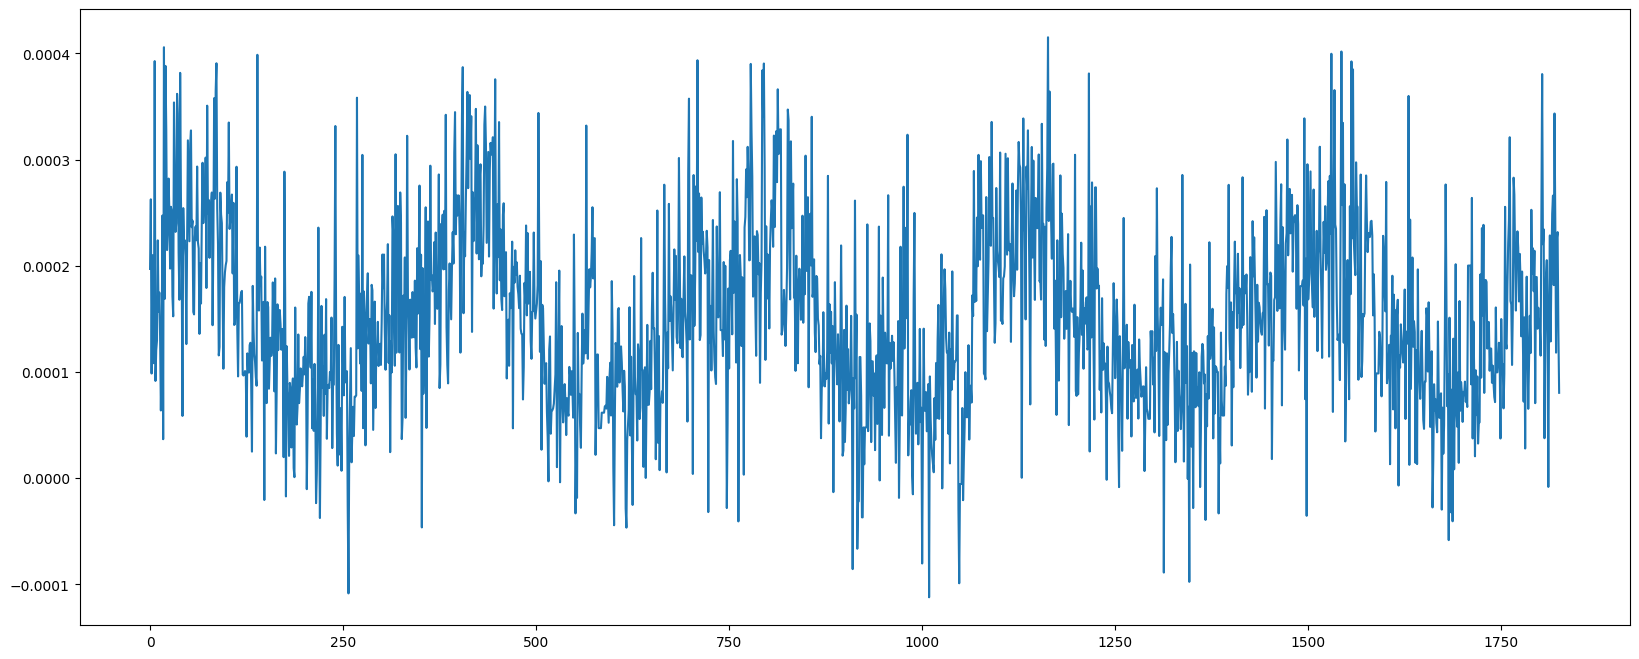

In [157]:
plt.figure(figsize=(20, 8))
plt.plot(scaler_y.inverse_transform(y_scaled))

In [158]:
print(X_scaled.head())

              carbon_monoxide  nitogen_dioxide      TMAX     ozone
Current Date                                                      
2019-01-01           1.108187         0.607974  0.353299 -0.570935
2019-01-02           1.108187         0.684846  0.353299 -0.570935
2019-01-03           0.342412         0.271008  0.798826 -0.570935
2019-01-04           0.623843         0.590368  1.244353 -0.570935
2019-01-05           0.451711         0.370446  0.798826 -0.570935


#### Apply multivariate time series model (Recurrent Neural Network)

In [159]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import L1
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import MeanAbsoluteError


# Now, split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X_scaled) * split_ratio)

X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential([
    Bidirectional(LSTM(units=120, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), # Adding a Dropout layer for regularization
    Bidirectional(LSTM(units=10, activation="tanh")),  # New Bidirectional LSTM layer
    Dropout(0.2),  # Adding a Dropout layer for regularization
    Dense(units=1)
])

optimizer = RMSprop(learning_rate=0.008)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_split=0.2)

Epoch 1/150
10/10 [==============================] - 19s 401ms/step - loss: 0.0870 - mean_squared_error: 0.0870 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 2/150
10/10 [==============================] - 0s 31ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 3/150
10/10 [==============================] - 0s 28ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 4/150
10/10 [==============================] - 0s 29ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0248 - val_mean_squared_error: 0.0248
Epoch 5/150
10/10 [==============================] - 0s 29ms/step - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 6/150
10/10 [==============================] - 0s 31ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0165 - val_mean_squared_error: 0.0165
Epoch 7/150
10/10 [=======

10/10 [==============================] - 0s 25ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0133 - val_mean_squared_error: 0.0133
Epoch 102/150
10/10 [==============================] - 0s 46ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 103/150
10/10 [==============================] - 0s 40ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 104/150
10/10 [==============================] - 0s 46ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 105/150
10/10 [==============================] - 0s 46ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 106/150
10/10 [==============================] - 1s 67ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 107/150
10/10 [=========

In [160]:
model.predict(X_test).shape

12/12 [==============================] - 4s 4ms/step


(366, 1)

12/12 [==============================] - 0s 5ms/step - loss: 0.0177 - mean_squared_error: 0.0177
Test Loss: [0.01772509701550007, 0.01772509701550007]
12/12 [==============================] - 0s 4ms/step


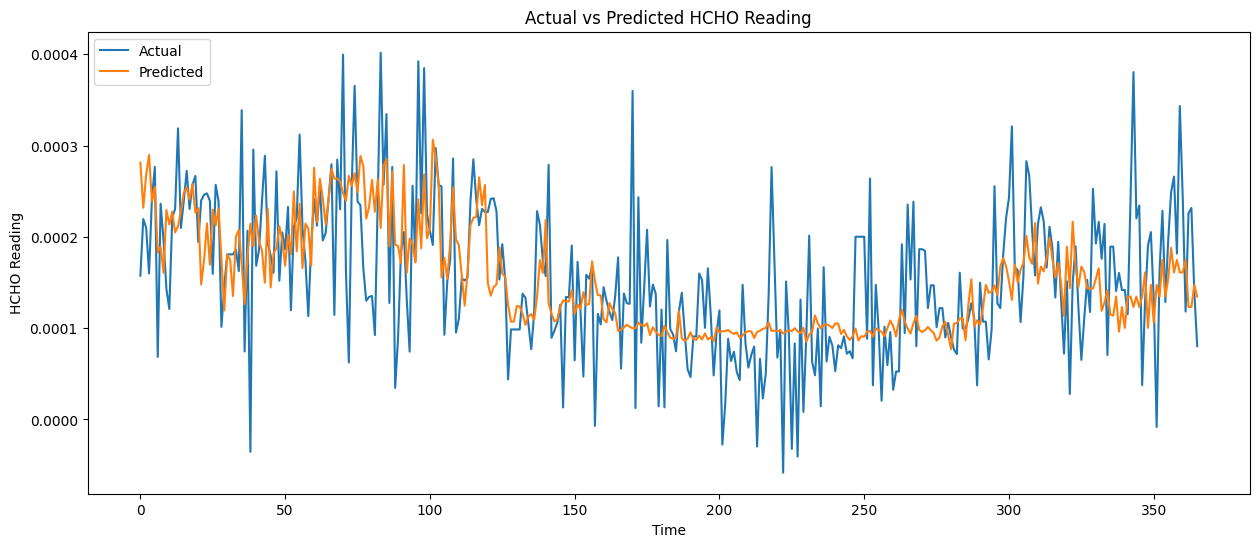

In [161]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, you can inverse transform the predictions to get them back to the original scale
predictions_inv = scaler_y.inverse_transform(predictions)
actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(actual, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.xlabel('Time')
plt.ylabel('HCHO Reading')
plt.title('Actual vs Predicted HCHO Reading')
plt.legend()
plt.show()

46/46 [==============================] - 1s 9ms/step


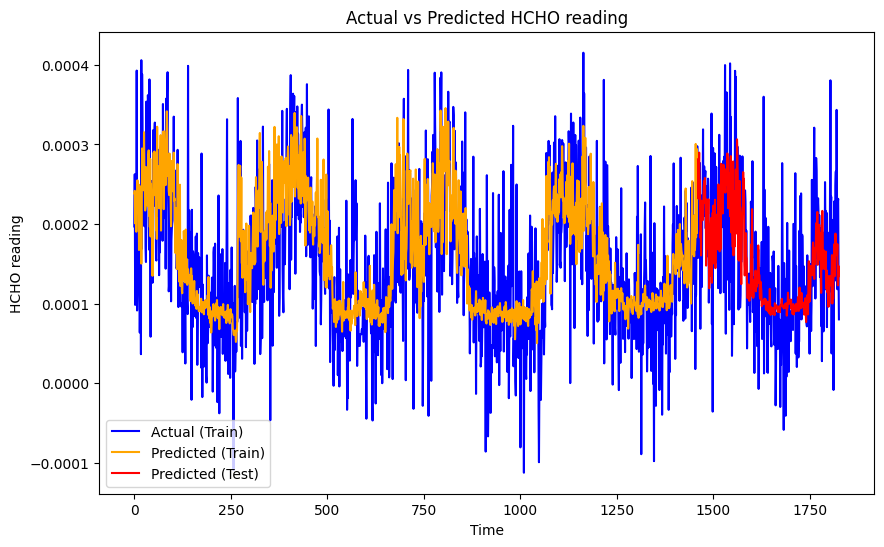

In [162]:
import matplotlib.pyplot as plt

# Predict values for testing data
predictions_scaled_test = model.predict(X_test)

# Inverse transform predictions and actual values to original scale for testing data
predictions_test = scaler_y.inverse_transform(predictions)
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Predict values for training data
predictions_scaled_train = model.predict(X_train)

# Inverse transform predictions and actual values to original scale for training data
predictions_train = scaler_y.inverse_transform(predictions_scaled_train)
actual_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data["HCHO reading"], label='Actual (Train)', color='blue')
plt.plot(predictions_train, label='Predicted (Train)', color='orange')
plt.plot(len(predictions_train) + np.arange(len(predictions_test)), predictions_test, label='Predicted (Test)', color='red')
plt.xlabel('Time')
plt.ylabel('HCHO reading')
plt.title('Actual vs Predicted HCHO reading')
plt.legend()
plt.show()

In [163]:
r2 = (r2_score(actual_test, predictions_test)) 
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test) 
rmse = mean_squared_error(actual_test, predictions_test, squared=False)
median_absolute = median_absolute_error(actual_test,predictions_test)
explained_variance = explained_variance_score(actual_test, predictions_test)

# Print evaluation metrics
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

R-squared (Coefficient of Determination): 0.2643643860855962
Mean Absolute Error (MAE): 5.262082599127674e-05
Mean Squared Error (MSE): 4.927897414620942e-09
Root Mean Squared Error (RMSE): 7.019898442727602e-05
Median Absolute Error: 3.941695649810272e-05
Explained Variance Score: 0.2669327756143418


#### Single Variate Time Series Models

#### Auto Regression model

In [66]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/colomboData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)

data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')


# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_ar = [] 

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(1, 0, 0))  # AR model with p=1, d=0, q=0 (since it's AR)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)[0]  # Forecasting 1 step ahead
    yhat_ar.append(predictions)

yhat_ar = pd.Series(yhat_ar, index=test.index)
ar_mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Print or store the results
print("ARIMA MSE:", ar_mse)


100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [05:15<00:00,  1.16it/s]

ARIMA MSE: 5.906283891409004e-09


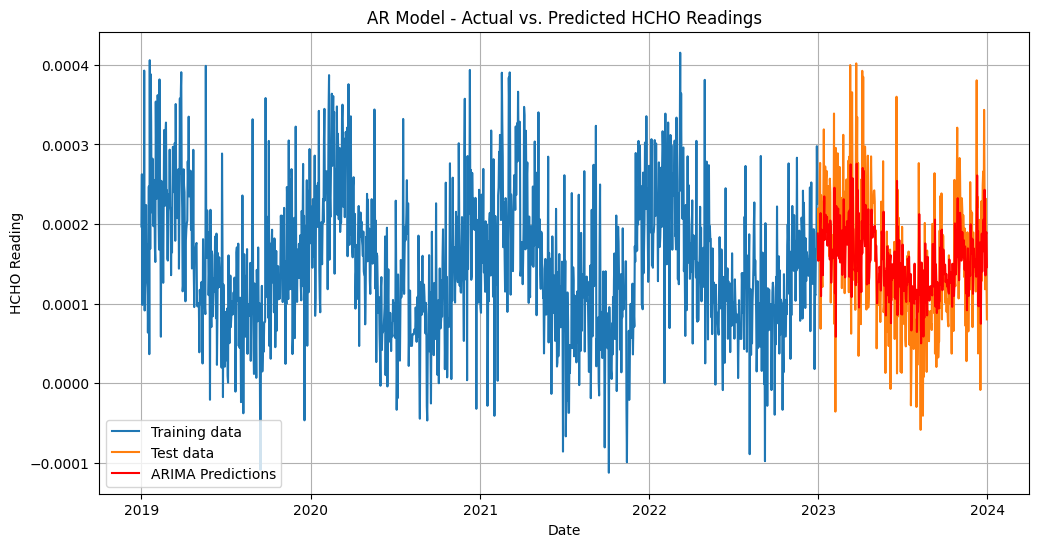

In [71]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_ar, label='ARIMA Predictions', color='red')
plt.title('AR Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

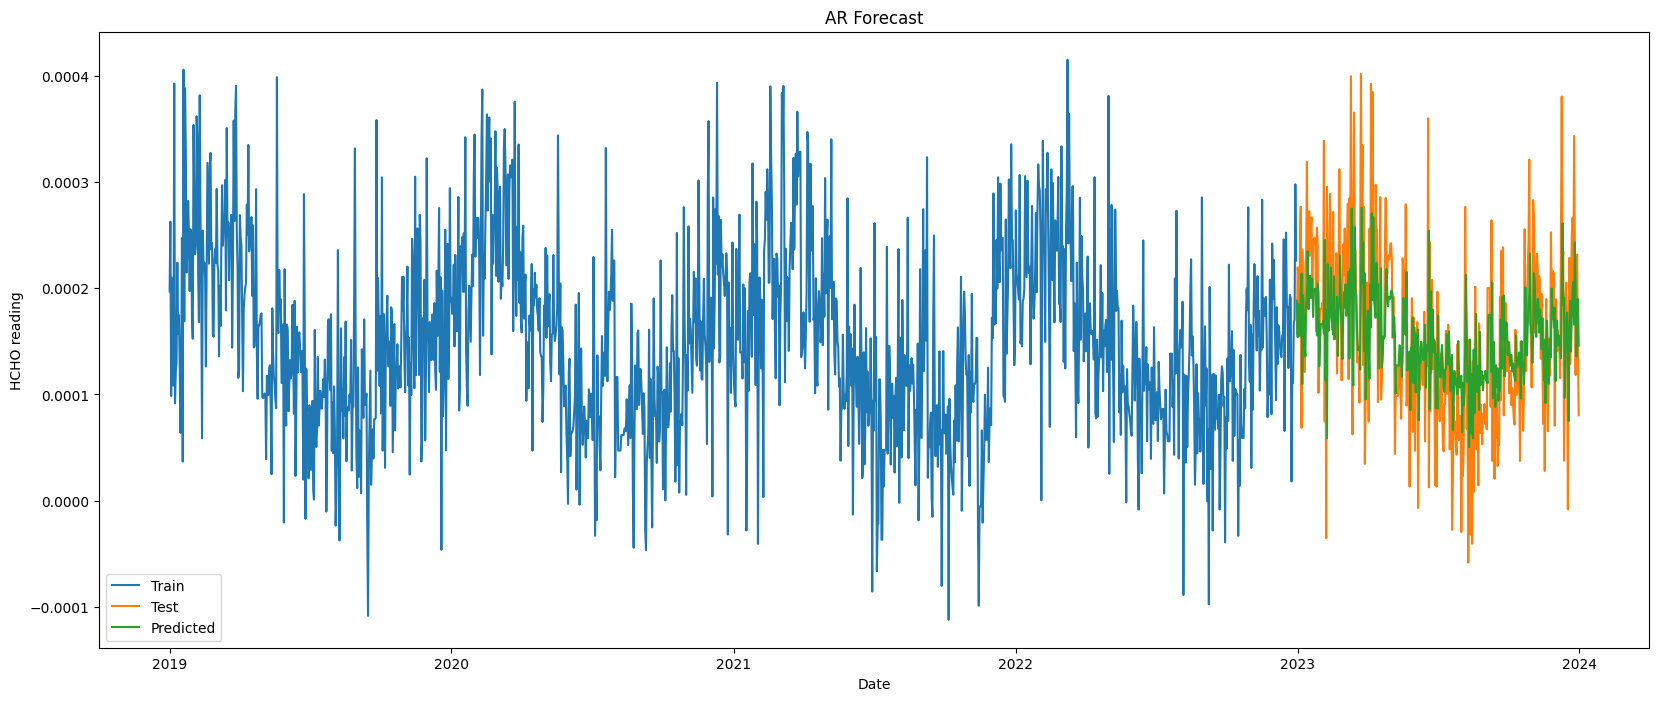

In [70]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train.index, train['HCHO reading'], label='Train')
plt.plot(test.index, test['HCHO reading'], label='Test')
plt.plot(test.index, yhat_ar, label='Predicted')

plt.title('AR Forecast')
plt.xlabel('Date')
plt.ylabel('HCHO reading')
plt.legend()
plt.show()


In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_ar)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_ar)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_ar) 

rmse = mean_squared_error(test['HCHO reading'], yhat_ar, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_ar)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_ar) 


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 5.9256599171951464e-05
Mean Squared Error (MSE): 5.906283891409004e-09
R-squared (R2) Score: 0.11831103392731068
Root Mean Squared Error (RMSE): 7.685235124190413e-05
Median Absolute Error: 4.7289262100116005e-05
Explained Variance Score: 0.11863045869519073


#### Single variate SARIMA model 

In [204]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from pmdarima import auto_arima

In [218]:
# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/colomboData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

In [219]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
# Find the best parameters using auto_arima

In [248]:
# Fit the SARIMAX Model
exog_train = train[['carbon_monoxide', 'nitrogen_dioxide', 'TMAX', 'ozone']]
endog_train = train['HCHO reading']

model = SARIMAX(endog_train, exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
model_fit = model.fit(disp=False)

# Forecast
exog_test = test[['carbon_monoxide', 'nitrogen_dioxide', 'TMAX', 'ozone']]
endog_test = test['HCHO reading']
predictions = model_fit.forecast(steps=len(test), exog=exog_test)

MSE:  4.962550573329234e-09


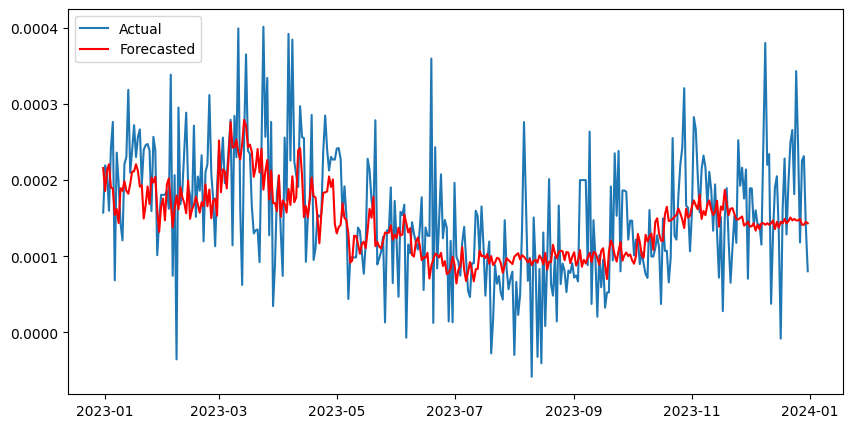

In [249]:
mse = mean_squared_error(endog_test, predictions)
print('MSE: ', mse)

# Plotting the results
plt.figure(figsize=(10,5))
plt.plot(endog_test.index, endog_test, label='Actual')
plt.plot(endog_test.index, predictions, label='Forecasted', color='red')
plt.legend()
plt.show()

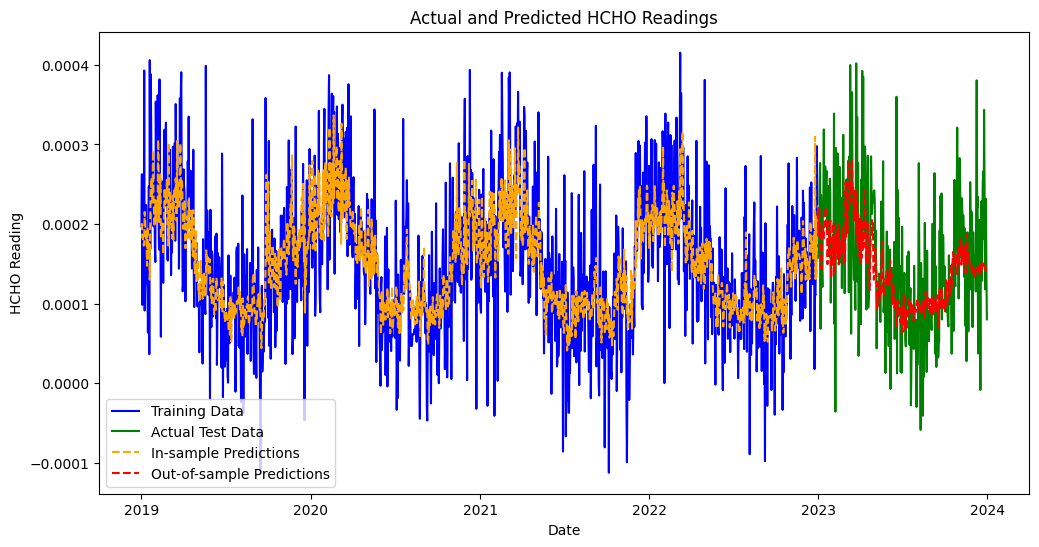

In [250]:
# Predict in-sample for the training data
in_sample_predictions = model_fit.predict(start=train.index[0], end=train.index[-1], exog=exog_train)

# Your existing code already handles forecasting the test data:
predictions = model_fit.forecast(steps=len(test), exog=exog_test)


in_sample_preds_series = pd.Series(in_sample_predictions, index=train.index)
predictions_series = pd.Series(predictions, index=test.index)

import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train['HCHO reading'], label='Training Data', color='blue')

# Plot testing data
plt.plot(test['HCHO reading'], label='Actual Test Data', color='green')

# Plot in-sample predictions
plt.plot(in_sample_preds_series, label='In-sample Predictions', color='orange', linestyle='--')

# Plot out-of-sample predictions
plt.plot(predictions_series, label='Out-of-sample Predictions', color='red', linestyle='--')

plt.title('Actual and Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.show()

In [251]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [252]:
# Calculate metrics for the training data
mse_train = mean_squared_error(train['HCHO reading'], in_sample_predictions)
mae_train = mean_absolute_error(train['HCHO reading'], in_sample_predictions)
r2_train = r2_score(train['HCHO reading'], in_sample_predictions)

print("Training Data Metrics:")
print("MSE:", mse_train)
print("MAE:", mae_train)
print("R^2 Score:", r2_train)

Training Data Metrics:
MSE: 4.370723619599204e-09
MAE: 4.9173825534794345e-05
R^2 Score: 0.4291417942871163


#### Single-variate ARIMA model

In [38]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/colomboData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# ARIMA example
yhat_arma = [] 

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = ARIMA(temp_train, order=(1, 0, 1))  # ARMA model with p=1,d=0,  q=1
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=10)[0]
    yhat_arma.append(predictions)

yhat_arma = pd.Series(yhat_arma, index=test.index)
arma_mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Print or store the results
print("ARIMA MSE:", arma_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [12:50<00:00,  2.10s/it]

ARIMA MSE: 5.1459560652207845e-09


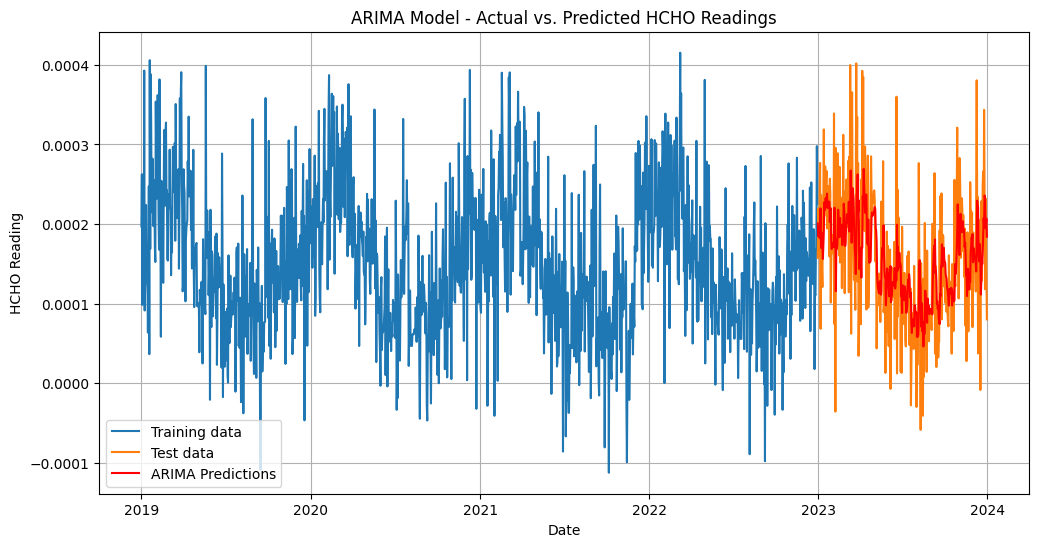

In [39]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

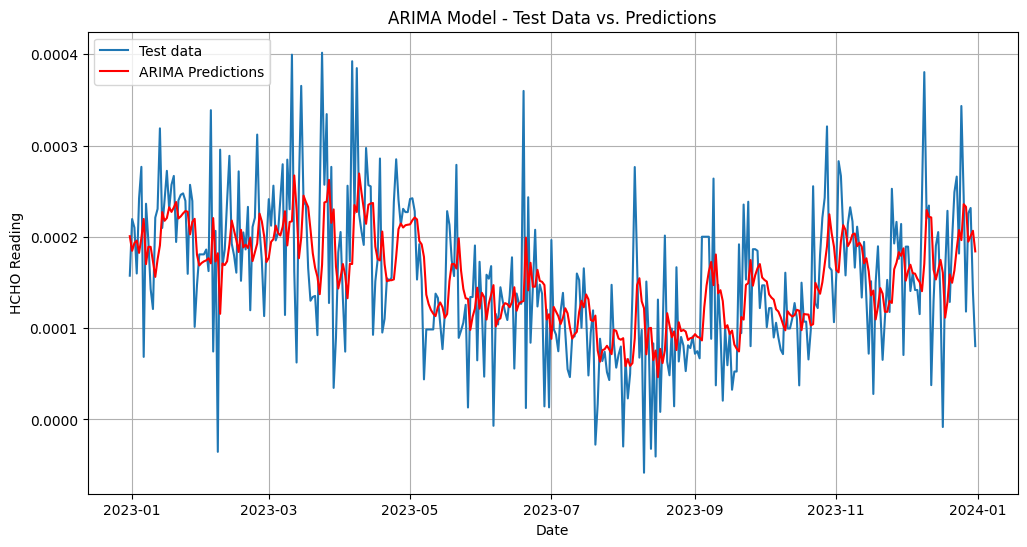

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_arma, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_arma)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_arma)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_arma)

rmse = mean_squared_error(test['HCHO reading'], yhat_arma, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_arma)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_arma)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 5.3044303043106867e-05
Mean Squared Error (MSE): 5.1459560652207845e-09
R-squared (R2) Score: 0.23181263108610606
Root Mean Squared Error (RMSE): 7.173531951013241e-05
Median Absolute Error: 3.7828691506857544e-05
Explained Variance Score: 0.23181358026060794


#### SARIMA model technique(2)

In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# Assuming 'data' is your DataFrame that includes the HCHO readings
# Let's mock the DataFrame here
data = pd.read_csv("../AnalysedFinalData/colomboData.csv", parse_dates=True)
data.drop(columns=["Next Date"], inplace=True)
data_dict = {
    'carbon_monoxide': data["carbon_monoxide"],
    'nitrogen_dioxide': data["nitogen_dioxide"],
    'TMAX': data["TMAX"],
    'ozone': data["ozone"],
    'HCHO reading': data["HCHO reading"]
}
data = pd.DataFrame(data_dict)
data.index = pd.date_range(start='2019-01-01', periods=len(data), freq='D')

# Splitting the data into training and test sets
train_size = int(len(data) * 0.8)  # 80% of data for training, 20% for testing
train = data.iloc[:train_size]
test = data.iloc[train_size:]

# SARIMA example
yhat_sarima = []

for t in tqdm(range(len(test['HCHO reading']))):
    temp_train = data['HCHO reading'][:train_size + t]
    model = SARIMAX(temp_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))  # SARIMA model with p=1,d=0,q=1 and seasonal order (P,D,Q,s) = (1,0,1,12)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=1)  # Forecasting 10 steps ahead
    yhat_sarima.append(predictions[-1])  # Appending only the last value of the forecast

yhat_sarima = pd.Series(yhat_sarima, index=test.index)
sarima_mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Print or store the results
print("SARIMA MSE:", sarima_mse)

100%|████████████████████████████████████████████████████████████████████████████████| 366/366 [18:29<00:00,  3.03s/it]

SARIMA MSE: 5.754202082842608e-09


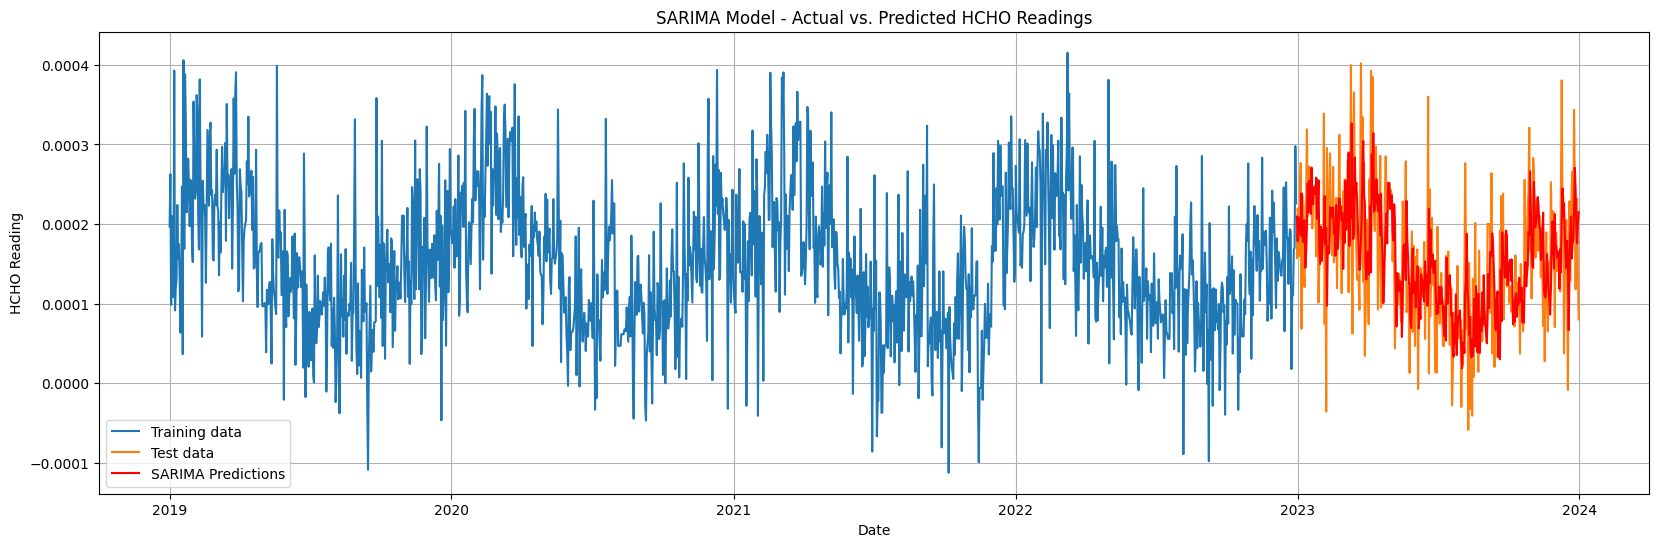

In [78]:
# Plotting
plt.figure(figsize=(20, 6))
plt.plot(train.index, train['HCHO reading'], label='Training data')
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Actual vs. Predicted HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True) 
plt.show()

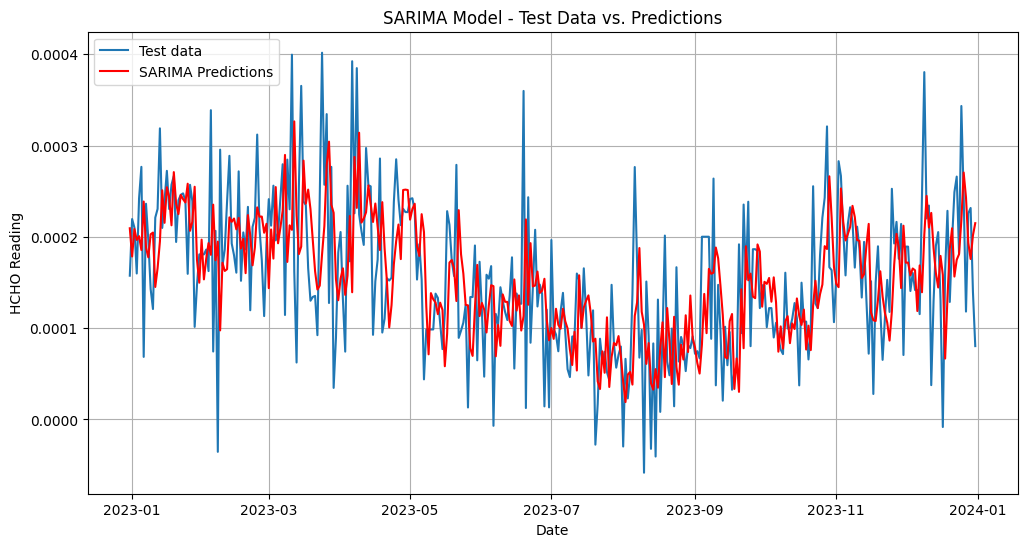

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['HCHO reading'], label='Test data')
plt.plot(test.index, yhat_sarima, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model - Test Data vs. Predictions')
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(test['HCHO reading'], yhat_sarima)

# Calculate MSE
mse = mean_squared_error(test['HCHO reading'], yhat_sarima)

# Calculate R2 score
r2 = r2_score(test['HCHO reading'], yhat_sarima)

rmse = mean_squared_error(test['HCHO reading'], yhat_sarima, squared=False)

median_absolute = median_absolute_error(test['HCHO reading'],yhat_sarima)

explained_variance = explained_variance_score(test['HCHO reading'], yhat_sarima)


# Print the results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2) Score:", r2)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Median Absolute Error: {median_absolute}")
print(f"Explained Variance Score: {explained_variance}")

Mean Absolute Error (MAE): 5.683813063634956e-05
Mean Squared Error (MSE): 5.754202082842608e-09
R-squared (R2) Score: 0.14101377816017935
Root Mean Squared Error (RMSE): 7.58564570939258e-05
Median Absolute Error: 4.243033823462473e-05
Explained Variance Score: 0.14103879832561683
